# Tutorial 5 - Operator Learning - Convolutional Neural Operator


- In this tutorial, you will learn how to apply Convolutional Neural Operators (CNOs) to solve 1D partial differential equations (PDEs). We will begin by introducing the concept of operator learning—models that learn mappings between functions rather than individual data points.

- You will then implement a 1D CNO from scratch in PyTorch, step by step, exploring its key architectural components such as lifting and projection layers, residual connections, and anti-aliasing operations.

- By the end of this tutorial, you will have both the theoretical understanding and practical coding skills to implement and train CNOs.

## Convolutional Neural Operators

In **operator learning**, models are tasked with handling functions as inputs

and outputs, which are stored on a computer in their **discrete representations** (e.g. images). They should have ability to process and generalize across various representations of the inputs, such as different mesh refinements.

Data-driven models that exhibit the mentioned properties are commonly known as ***Neural Operators***.

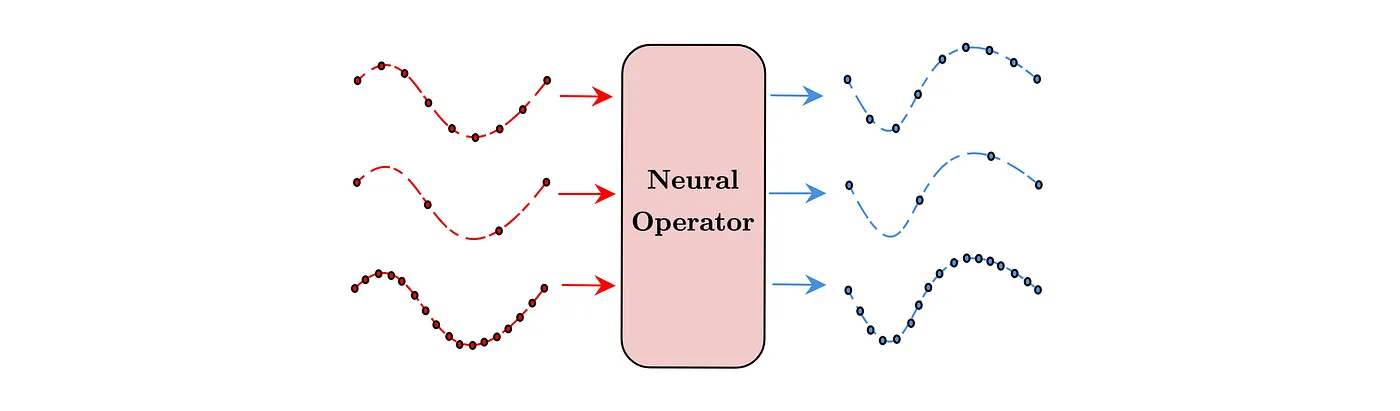




- Introduced in the paper [Convolutional Neural Operators for robust and accurate learning of PDEs
](https://arxiv.org/abs/2302.01178).
- CNO is formulated as an **iterative architecture**
- CNO uses **convolutions** parametrized in the **physical domain** (**local** operations)
- CNO uses U-Net like architecture for multi-scale learning
- CNO uses **skip connections** to enchance the training

First layer is the **lifting layer** (in the channel dimension, increases the number of channels), while the last layer is the **projection layer** (reduces the number of channels).


- You can read the CNO blog on [this link](https://medium.com/@bogdan.raonke/operator-learning-convolutional-neural-operators-for-robust-and-accurate-learning-of-pdes-ebbc43b57434).

- Given the short length of this tutorial, we will not implement optimized and controllable filtering operations for higher-accuracy predictions. Instead, we will use PyTorch’s built-in antialias interpolation. Similarly, automatic resolution transfer to the computational grid will also be performed using PyTorch’s built-in filtering functions. Alternatively, this transfer could be carried out directly in the frequency domain via FFT. The latter was the method used in the CNO paper.

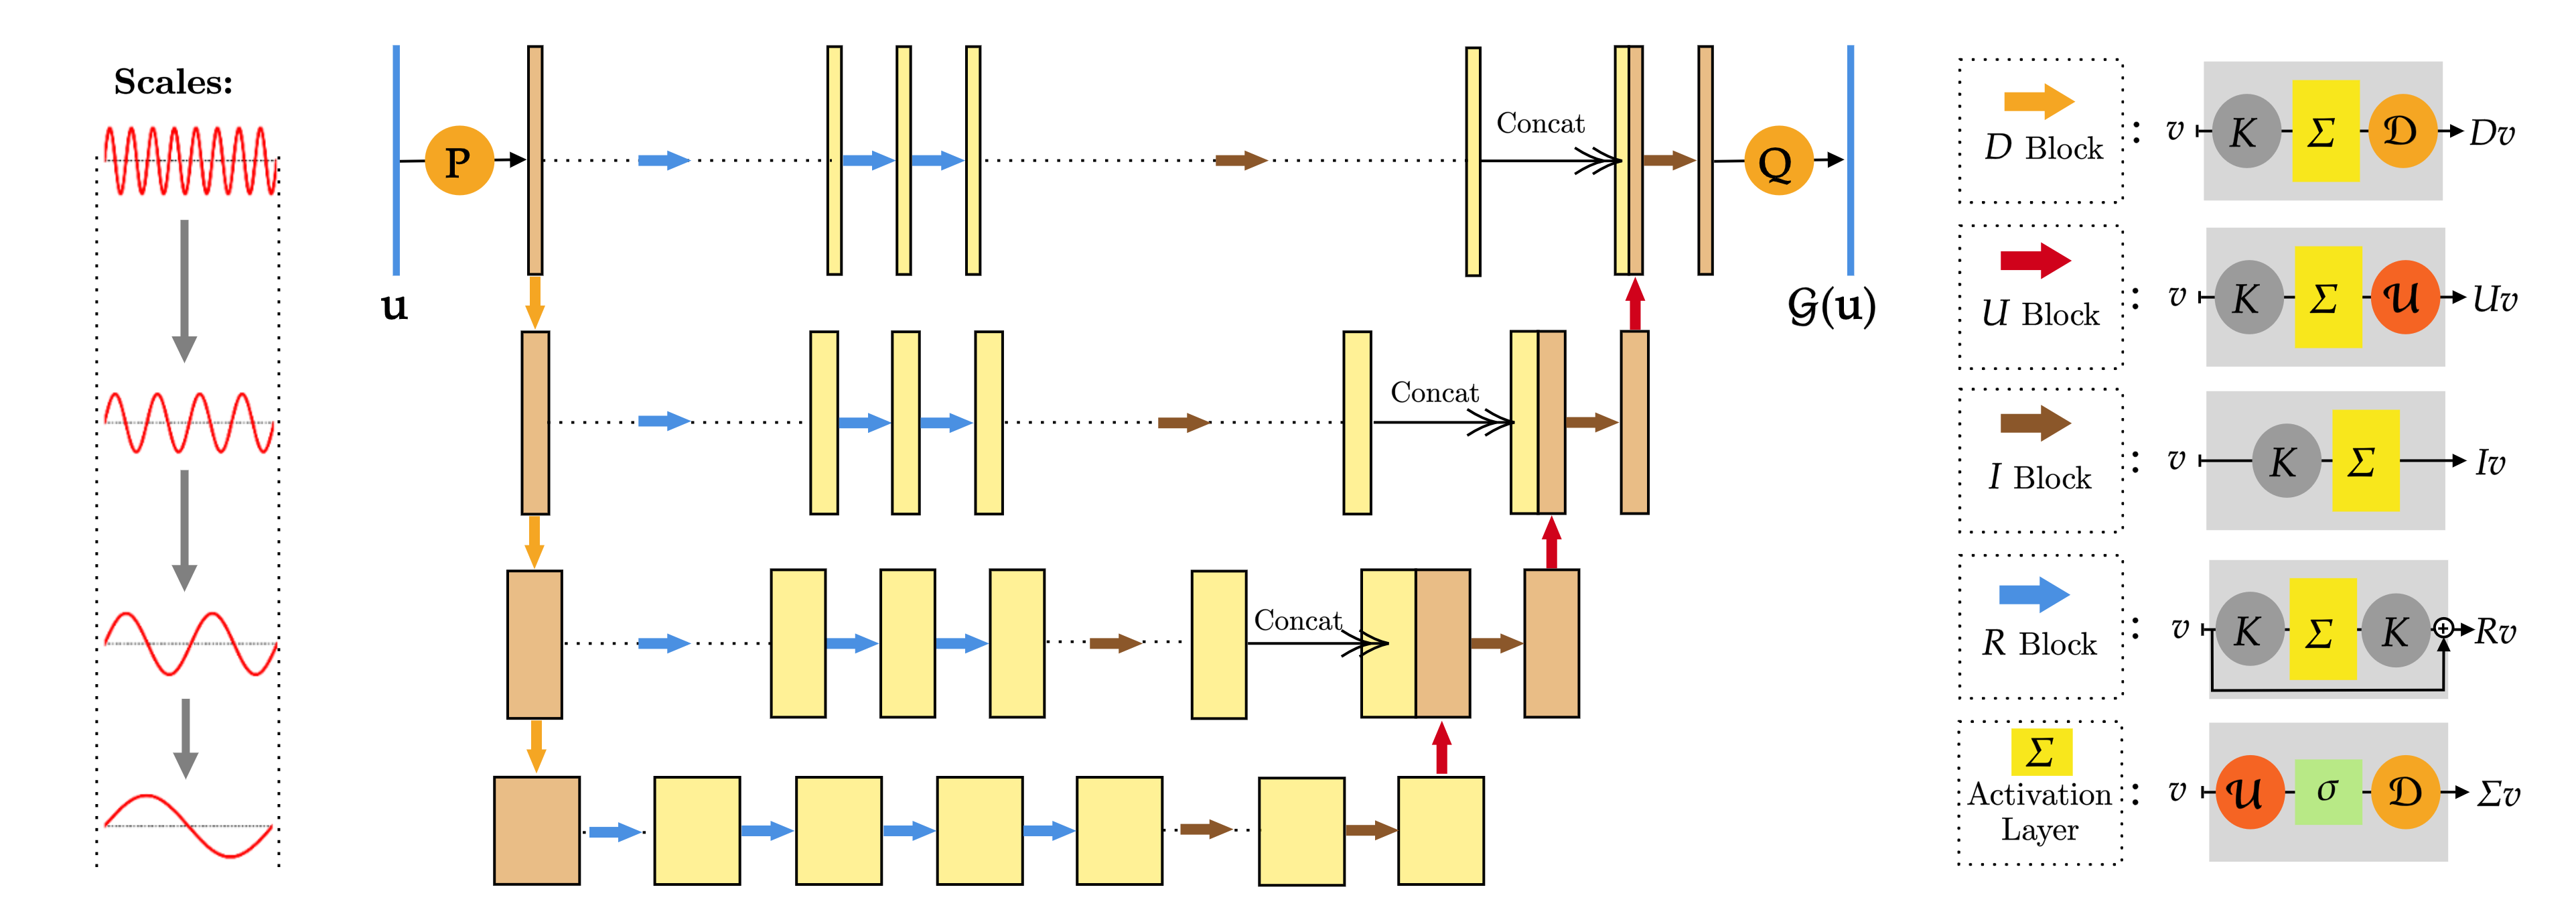

Solutions of PDEs are operators that act as mappings between function spaces. They take initial conditions, boundary conditions, and source terms as inputs and yield the PDE solution as output. For instance, in fluid dynamics, the solution operator can compute the flow profile at a specific future time (e.g. $T = 1$) given the initial flow and boundary conditions.


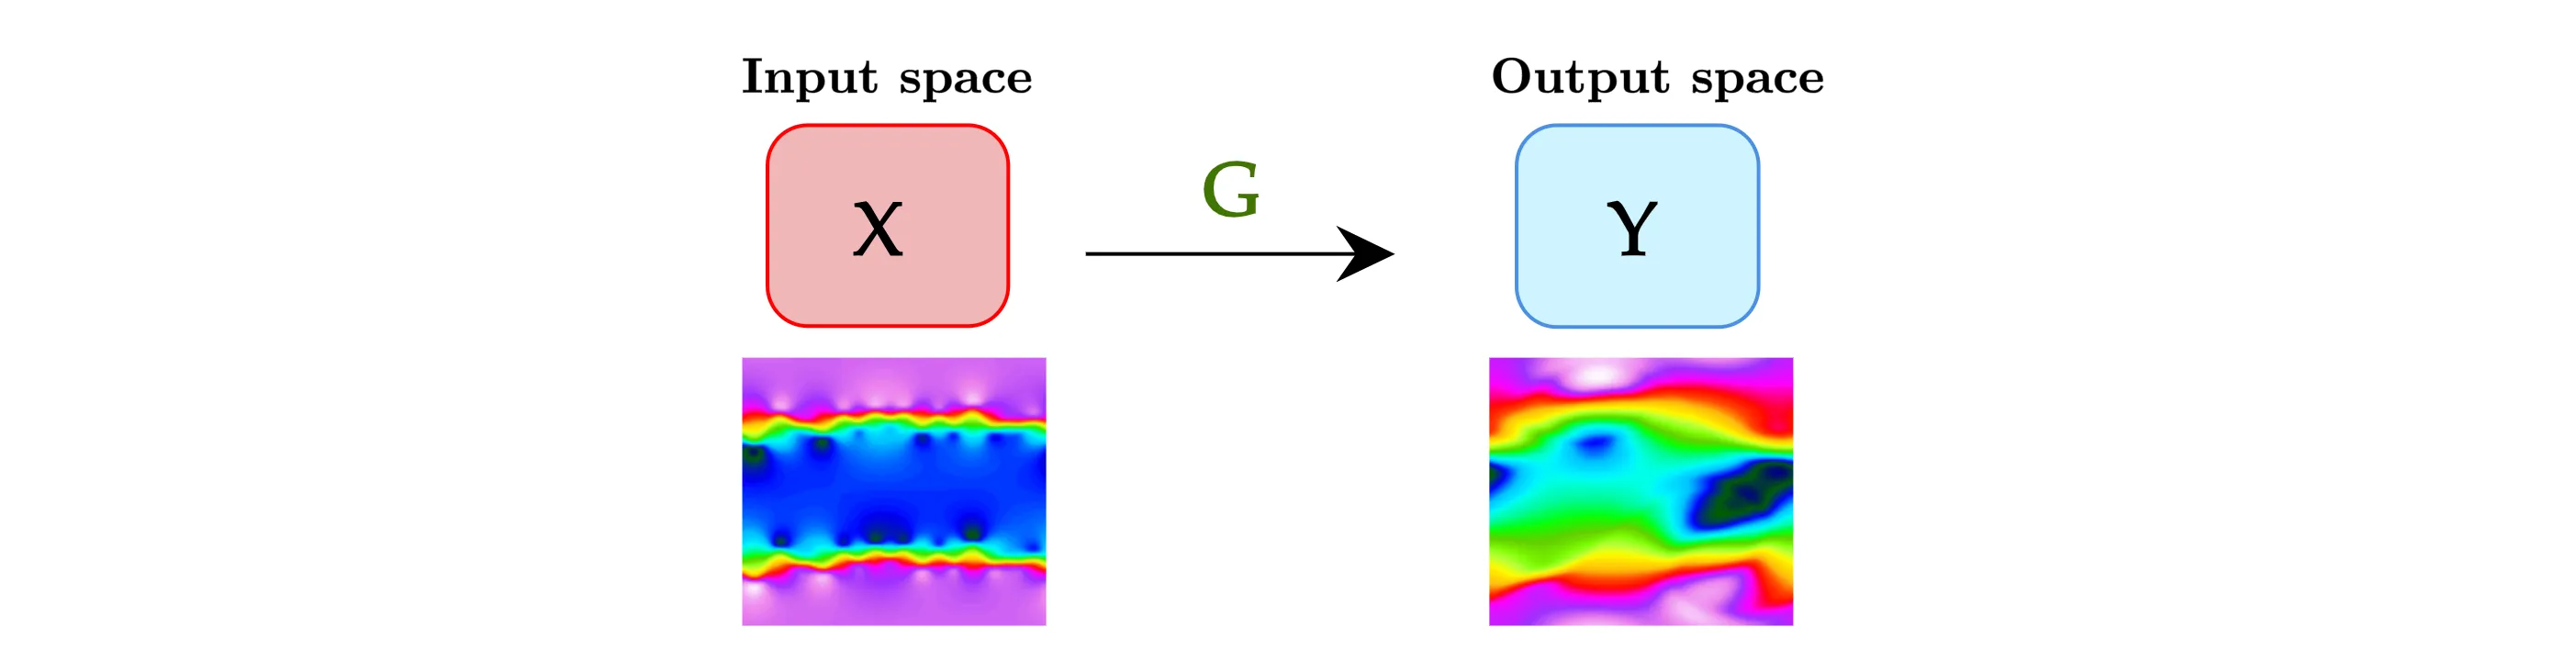

### The Pipeline

- **In this notebook, we will implement 1d, time-independent pytorch version of the CNO model**.
- We will use **antialias interpoaltion** from the torch library.
- [LINK TO THE DATA](https://drive.google.com/drive/folders/17CDNE96WxgiB6O4cE5TKoVECTE4U22rY?usp=sharing) - Please download the data and attach all the files to the notebook (left panel)

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt

In the following code, we will define
* **CNO LReLu** activation fucntion
* **CNO building block** (CNOBlock) → Conv1d - BatchNorm - Activation
* **Lift/Project Block** (Important for embeddings)
* **Residual Block** → Conv1d - BatchNorm - Activation - Conv1d - BatchNorm - *Skip Connection*
* **ResNet** → Stacked ResidualBlocks (several blocks applied iteratively)

In [2]:
#---------------------
# BN:
#---------------------

class NormalizationLayer(torch.nn.Module):
    def __init__(self,
                channels):
        super(NormalizationLayer, self).__init__()
        self.channels = channels
        self.norm = nn.BatchNorm1d(channels)

    def forward(self, x):
        print(x.shape)
        return self.norm(x)


In [3]:
#---------------------
# Activation Function:
#---------------------

class CNO_LReLu(nn.Module):
    def __init__(self,
                 in_size,
                 out_size
                 ):
        super(CNO_LReLu, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.act = nn.LeakyReLU()

    def forward(self, x):

      x = F.interpolate(x.unsqueeze(2), size = (1,2 * self.in_size), mode = "bicubic", antialias = True)
      x = self.act(x)
      x = F.interpolate(x, size = (1,self.out_size), mode = "bicubic", antialias = True)

      return x[:,:,0]

#--------------------
# CNO Block:
#--------------------

class CNOBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 in_size,
                 out_size,
                 use_bn = True
                 ):
        super(CNOBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.in_size  = in_size
        self.out_size = out_size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation
        # Up/Downsampling happens inside Activation

        self.convolution = torch.nn.Conv1d(in_channels = self.in_channels,
                                           out_channels= self.out_channels,
                                           kernel_size = 3,
                                           padding     = 1)

        self.batch_norm  = NormalizationLayer(self.out_channels)

        self.act           = CNO_LReLu(in_size  = self.in_size,
                                       out_size = self.out_size)


    def forward(self, x):
        x = self.convolution(x)
        x = self.batch_norm(x)
        return self.act(x)

#--------------------
# Lift/Project Block:
#--------------------

class LiftProjectBlock(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                size,
                latent_dim = 64
                ):
        super(LiftProjectBlock, self).__init__()

        self.inter_CNOBlock = CNOBlock(in_channels       = in_channels,
                                        out_channels     = latent_dim,
                                        in_size          = size,
                                        out_size         = size,
                                        use_bn           = False)

        self.convolution = torch.nn.Conv1d(in_channels  = latent_dim,
                                           out_channels = out_channels,
                                           kernel_size  = 3,
                                           padding      = 1)


    def forward(self, x):
        x = self.inter_CNOBlock(x)
        x = self.convolution(x)
        return x

#--------------------
# Residual Block:
#--------------------

class ResidualBlock(nn.Module):
    def __init__(self,
                 channels,
                 size,
                 use_bn = True
                 ):
        super(ResidualBlock, self).__init__()

        self.channels = channels
        self.size     = size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation -> Conv -> BN (optional) -> Skip Connection
        # Up/Downsampling happens inside Activation

        self.convolution1 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)
        self.convolution2 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)

        self.batch_norm1  = NormalizationLayer(self.channels)
        self.batch_norm2  = NormalizationLayer(self.channels)

        self.act           = CNO_LReLu(in_size  = self.size,
                                       out_size = self.size)


    def forward(self, x):
        out = self.convolution1(x)
        out = self.batch_norm1(out)
        out = self.act(out)
        out = self.convolution2(out)
        out = self.batch_norm2(out)
        return x + out

#--------------------
# ResNet:
#--------------------

class ResNet(nn.Module):
    def __init__(self,
                 channels,
                 size,
                 num_blocks,
                 use_bn = True
                 ):
        super(ResNet, self).__init__()

        self.channels = channels
        self.size = size
        self.num_blocks = num_blocks

        self.res_nets = []
        for _ in range(self.num_blocks):
            self.res_nets.append(ResidualBlock(channels = channels,
                                              size = size,
                                              use_bn = use_bn))

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x):
        for i in range(self.num_blocks):
            x = self.res_nets[i](x)
        return x

In [4]:
X = torch.rand((1,2,128))

#-------------
# Check your normalization layer
#-------------
norm = NormalizationLayer(channels=2)
Y = norm(X)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your activation
#-------------
cno_lrelu = CNO_LReLu(in_size  = 128,
                      out_size = 128)
Y = cno_lrelu(X)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your CNOBlock
#-------------
cno_block = CNOBlock(in_channels = 2,
                    out_channels = 4,
                    in_size = 128,
                    out_size = 64,
                    use_bn = True)
Y = cno_block(X)
assert tuple(Y.shape) == (1,4,64)

#-------------
# Check your LiftProjectBlock
#-------------
lift_project = LiftProjectBlock(in_channels = 2,
                                out_channels = 4,
                                size = 128)
Y = lift_project(X)
assert tuple(Y.shape) == (1,4,128)

#-------------
# Check your ResidualBlock
#-------------
residual_bl = ResidualBlock(channels = 2,
                            size = 128,
                            use_bn = True)
Y = residual_bl(X)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your ResNet
#-------------
res_net = ResNet(channels = 2,
                 size = 128,
                 num_blocks = 3,
                 use_bn = True)
Y = res_net(X)
assert tuple(Y.shape) == (1,2,128)


torch.Size([1, 2, 128])
torch.Size([1, 4, 128])
torch.Size([1, 64, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128])
torch.Size([1, 2, 128])


####Once that all the CNO ingredients are implemented, we can code the **CNO model**
- CNO model has a UNet like architecture with additional ResNets that connect corresponding levels of the **encoder** and the **decoder**
- As in the case of FNO, there are **lifting** and **projection** layers.
- We assume that the input and the output sizes are equal, although, one can easily generalize to different sizes.

In [5]:
#--------------------
# CNO:
#--------------------

class CNO1d(nn.Module):
    def __init__(self,
                 in_dim,                    # Number of input channels.
                 out_dim,                   # Number of input channels.
                 size,                      # Input and Output spatial size - COMPUTATIONAL RESOLUTION
                 N_layers,                  # Number of (D) or (U) blocks in the network
                 N_res = 4,                 # Number of (R) blocks per level (except the neck)
                 N_res_neck = 4,            # Number of (R) blocks in the neck
                 channel_multiplier = 16,   # How the number of channels evolve?
                 use_bn = True,             # Add BN? We do not add BN in lifting/projection layer
                ):

        super(CNO1d, self).__init__()

        self.N_layers = int(N_layers)         # Number od (D) & (U) Blocks
        self.lift_dim = channel_multiplier//2 # Input is lifted to the half of channel_multiplier dimension
        self.in_dim   = in_dim
        self.out_dim  = out_dim
        self.computational_size = size
        self.channel_multiplier = channel_multiplier  # The growth of the channels

        ######## Num of channels/features - evolution ########

        self.encoder_features = [self.lift_dim] # How the features in Encoder evolve (number of features)
        for i in range(self.N_layers):
            self.encoder_features.append(2 ** i *   self.channel_multiplier)

        self.decoder_features_in = self.encoder_features[1:] # How the features in Decoder evolve (number of features)
        self.decoder_features_in.reverse()
        self.decoder_features_out = self.encoder_features[:-1]
        self.decoder_features_out.reverse()

        for i in range(1, self.N_layers):
            self.decoder_features_in[i] = 2*self.decoder_features_in[i] #Pad the outputs of the resnets (we must multiply by 2 then)

        ######## Spatial sizes of channels - evolution ########

        self.encoder_sizes = []
        self.decoder_sizes = []
        for i in range(self.N_layers + 1):
            self.encoder_sizes.append(size // 2 ** i)
            self.decoder_sizes.append(size // 2 ** (self.N_layers - i))


        ######## Define Lift and Project blocks ########

        self.lift   = LiftProjectBlock(in_channels = in_dim,
                                      out_channels = self.encoder_features[0],
                                      size = size)

        self.project   = LiftProjectBlock(in_channels = self.encoder_features[0] + self.decoder_features_out[-1],
                                          out_channels = out_dim,
                                          size = size)

        ######## Define Encoder, ED Linker and Decoder networks ########

        self.encoder         = nn.ModuleList([(CNOBlock(in_channels  = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i+1],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.encoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers)])

        # After the ResNets are executed, the sizes of encoder and decoder might not match (if out_size>1)
        # We must ensure that the sizes are the same, by aplying CNO Blocks
        self.ED_expansion     = nn.ModuleList([(CNOBlock(in_channels = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.decoder_sizes[self.N_layers - i],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers + 1)])

        self.decoder         = nn.ModuleList([(CNOBlock(in_channels  = self.decoder_features_in[i],
                                                        out_channels = self.decoder_features_out[i],
                                                        in_size      = self.decoder_sizes[i],
                                                        out_size     = self.decoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers)])

        ####################### Define ResNets Blocks ################################################################

        # Here, we define ResNet Blocks.

        # Operator UNet:
        # Outputs of the middle networks are patched (or padded) to corresponding sets of feature maps in the decoder

        self.res_nets = []
        self.N_res = int(N_res)
        self.N_res_neck = int(N_res_neck)

        # Define the ResNet networks (before the neck)
        for l in range(self.N_layers):
              self.res_nets.append(ResNet(channels = self.encoder_features[l],
                                          size = self.encoder_sizes[l],
                                          num_blocks = self.N_res,
                                          use_bn = use_bn))

        self.res_net_neck = ResNet(channels = self.encoder_features[self.N_layers],
                                  size = self.encoder_sizes[self.N_layers],
                                  num_blocks = self.N_res_neck,
                                  use_bn = use_bn)

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x):

      size = x.shape[-1]
      if self.computational_size!=size:
        x = F.interpolate(x.unsqueeze(2), size = (1,self.computational_size), mode = "bicubic", antialias = True)[:,:,0]

      x = self.lift(x) #Execute Lift
      skip = []

      # Execute Encoder
      for i in range(self.N_layers):

          #Apply ResNet & save the result
          y = self.res_nets[i](x)
          skip.append(y)

          # Apply (D) block
          x = self.encoder[i](x)


      # Apply the deepest ResNet (bottle neck)
      x = self.res_net_neck(x)

      # Execute Decode
      for i in range(self.N_layers):

          # Apply (I) block (ED_expansion) & cat if needed
          if i == 0:
              x = self.ED_expansion[self.N_layers - i](x) #BottleNeck : no cat
          else:
              x = torch.cat((x, self.ED_expansion[self.N_layers - i](skip[-i])),1)

          # Apply (U) block
          x = self.decoder[i](x)

      # Cat & Execute Projetion
      x = torch.cat((x, self.ED_expansion[0](skip[0])),1)
      x = self.project(x)

      if self.computational_size!=size:
        x = F.interpolate(x.unsqueeze(2), size = (1,size), mode = "bicubic", antialias = True)[:,:,0]
      return x


### Task

We will solve an **unknown, time-independent PDE** from the data.

The data is given in terms of solution **trajectories**. Each trajectory has the spatial resolution $X$.

We wish to learn time-independent operator $G$

$$
G : u_0 \mapsto  u_T
$$

Note that the data is generated for you (see the file *pde_data.npy*)

In [6]:
class PDEDataset(Dataset):
    def __init__(self,
                 which="training",
                 training_samples = 256,
                 resolution = 128):

        self.resolution = resolution
        self.data = np.load(f"pde_data_{resolution}.npy")

        self.T = 5
        # Precompute all possible (t_initial, t_final) pairs within the specified range.

        self.N_max = 512
        self.n_val  = 32
        self.n_test = 32

        if which == "training":
            self.length = training_samples
            self.start = 0
        elif which == "validation":
            self.length = self.n_val
            self.start = (self.N_max - self.n_val - self.n_test)
        elif which == "test":
            self.length = self.n_test
            self.start = (self.N_max  - self.n_test)

        self.mean = 0
        self.std  = 0.3835

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        inputs = torch.from_numpy(self.data[index, 0]).type(torch.float32).reshape(1, 128)
        inputs = (inputs - self.mean)/self.std #Normalize

        outputs = torch.from_numpy(self.data[index, self.T]).type(torch.float32).reshape(1, 128)
        outputs = (outputs - self.mean)/self.std #Normalize

        return inputs, outputs

In [7]:
id_sample = 32
pde_data = np.load("pde_data_128.npy")

plt.scatter(np.linspace(0,1,128),pde_data[id_sample,0,:], s = 5)
plt.plot(np.linspace(0,1,128),pde_data[id_sample,0,:], label = "$u(t = 0)$")
plt.scatter(np.linspace(0,1,128),pde_data[id_sample,2,:], s = 5)
plt.plot(np.linspace(0,1,128),pde_data[id_sample,2,:], label = "$u(t = 0.4)$")
plt.scatter(np.linspace(0,1,128),pde_data[id_sample, 5,:], s = 5)
plt.plot(np.linspace(0,1,128),pde_data[id_sample, 5,:], label = "$u(t = 1)$")
plt.grid(True, which="both", ls=":")
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'pde_data_128.npy'

In [ ]:
n_train = 400 # Number of TRAJECTORIES for training
batch_size = 10

training_set = DataLoader(PDEDataset("training", n_train), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(PDEDataset("validation"), batch_size=batch_size, shuffle=False)

learning_rate = 0.0005
epochs = 20
step_size = 2
gamma = 0.5

In [ ]:
N_layers = 4
N_res    = 1
N_res_neck = 4
channel_multiplier = 16

cno = CNO1d(in_dim = 1,                                    # Number of input channels.
            out_dim = 1,                                   # Number of input channels.
            size = 128,                                    # Computational size
            N_layers = N_layers,                           # Number of (D) or (U) blocks in the network
            N_res = N_res,                                 # Number of (R) blocks per level (except the neck)
            N_res_neck = N_res_neck,                       # Number of (R) blocks in the neck
            channel_multiplier = channel_multiplier,       # How the number of channels evolve?
            use_bn = False)


### Training

Note that it takes a few minutes to train a model for 1 epoch on a CPU!

In [ ]:
optimizer = AdamW(cno.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = nn.L1Loss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = cno(input_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        cno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = cno(input_batch,)
            loss_f = (torch.mean((abs(output_pred_batch - output_batch))) / torch.mean(abs(output_batch))) * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L1 Test Norm:", test_relative_l2)



### Testing

In [ ]:
def test_model(idx_test, model, pde_data, size = 128, mean = 0., std = 0.3835):

  inputs = torch.from_numpy(pde_data[idx_test, 0]).type(torch.float32).reshape(1,1, size)
  inputs = (inputs - mean)/std

  outputs = torch.from_numpy(pde_data[idx_test, 5]).type(torch.float32).reshape(1,1, size)
  output_pred = model(inputs) * std + mean

  outputs = outputs.numpy()
  output_pred = output_pred.detach().numpy()

  return outputs, output_pred

def get_mean_error(model, pde_data, size = 128, mean = 0., std = 0.3835):
  errs = []
  N_test = 32
  for idx in range(N_test):
    output, output_pred = test_model(idx, model, pde_data, size = size, mean = mean, std = std)
    errs.append(np.mean(np.abs(output - output_pred))/np.mean(np.abs(output)))

  return np.array(errs)

In [ ]:
size = 128
pde_data_test = np.load(f"pde_data_{size}.npy")[-128:]

cno.eval()
outputs, output_pred = test_model(idx_test = 0, model = cno, pde_data = pde_data_test, size = size)

plt.figure()
plt.grid(True, which="both", ls=":")
X = np.linspace(0,1, size)
plt.plot(X,outputs[0,0], label="True Solution", c="C0", lw=2)
plt.scatter(X,output_pred[0,0], label=f"Approximation at T", c="C1")
plt.legend()

- Test the trained model at different resolutions, specified below.

- What do you observe?

In [ ]:
R = [48, 64, 80, 96, 112, 128, 160, 192, 224, 256] # Resolutions
E = []

for res in R:
  pde_data_test = np.load(f"pde_data_{res}.npy")[-128:]
  errs = get_mean_error(cno, pde_data = pde_data_test, size = res, mean = 0., std = 0.3835)
  E.append(np.mean(errs))
  print(np.mean(errs))

In [ ]:
plt.scatter(R,E)
plt.plot(R,E)
plt.grid(True)

plt.scatter([128], [E[5]], s= 50, color = "red", label = "Train Res.")
plt.xlabel("Resolution", fontsize = 16)
plt.ylabel("Relative Error", fontsize = 16)
plt.legend(fontsize = 14)

### Official CNO2d repo can be found [here](https://github.com/bogdanraonic3/ConvolutionalNeuralOperator/tree/main)
